# Data Loading

In [1]:
spark.conf.set("spark.sql.shuffle.partitions", 1000)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [2]:
from pyspark.sql.types import DateType, IntegerType
from pyspark.sql.functions import from_unixtime, unix_timestamp,to_date, max, when
from pyspark.sql.functions import col, sum, greatest, expr, count, countDistinct, concat,substring, lit, length, lpad
from pyspark.sql.types import *
from pyspark.sql.functions import broadcast
from pyspark.ml.recommendation import ALS, ALSModel
import pandas as pd
import matplotlib.pylab as plt

from pyspark.ml.clustering import KMeans, KMeansModel, BisectingKMeans, BisectingKMeansModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, PCAModel, ElementwiseProduct
from pyspark.ml import Pipeline, PipelineModel
#import datetime

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
#FUNCIONES PARA EXTRAER NULOS POR COLUMNA
def count_null(col_name):
  return sum(col(col_name).isNull().cast('integer')).alias(col_name)

def mostrarNulos(dataframe):
    # Run the aggregation. The *exprs converts the list of expressions into
    # variable function arguments.
    exprs = []
    for col_name in dataframe.columns:
      exprs.append(count_null(col_name))
    return dataframe.agg(*exprs)

In [4]:
#PARA LOCAL DEL TRABAJO
#spark = SparkSession.builder.getOrCreate()

## Buffer Ticket

#### PRODUTOFAM

In [5]:
#LECTURA DE TABLA PARQUET
dfProdutofam=spark.read.parquet("/user/sparta-server/trusted/bufferticket/PRODUTOFAM")
dfProdutofam.persist()

DataFrame[PRF_CD_SUBFAMILIA: bigint, PRF_DS_SUBFAMILIA: string, PRF_CD_FAMILIA: bigint, PRF_DT_INCLUSAO: timestamp, PRF_DT_ALTERACAO: timestamp, TM_TRUSTED: timestamp, DT_TRUSTED: int]

In [6]:
dfProdutofam.printSchema()

root
 |-- PRF_CD_SUBFAMILIA: long (nullable = true)
 |-- PRF_DS_SUBFAMILIA: string (nullable = true)
 |-- PRF_CD_FAMILIA: long (nullable = true)
 |-- PRF_DT_INCLUSAO: timestamp (nullable = true)
 |-- PRF_DT_ALTERACAO: timestamp (nullable = true)
 |-- TM_TRUSTED: timestamp (nullable = true)
 |-- DT_TRUSTED: integer (nullable = true)



In [ ]:
dfProdutofam.describe().show()

In [14]:
#DETECTAR DUPLICADOS
dfProdutofam.count()

3076

In [7]:
dfProdutofam.select("PRF_CD_SUBFAMILIA").distinct().count()

3076

In [13]:
dfProdutofam=dfProdutofam.dropDuplicates(["PRF_CD_SUBFAMILIA"])

In [ ]:
#CONVERSION A FECHA, PARA CUANDO SEA NECESARIO

#dfProdutofam.select("PRF_DT_INCLUSAO").cast(DateType)
#dfProdutofam.withColumn("record_date",dfProdutofam['PRF_DT_INCLUSAO'].cast(DateType())).show()
#dfProdutofam.withColumn("parsed", to_date(to_timestamp("PRF_DT_INCLUSAO", "dd/MM/yy"))).show()
dfProdutofam.withColumn("parsed", to_date(from_unixtime(unix_timestamp("PRF_DT_INCLUSAO", "dd/MM/yy")))).show()

#ESCRITURA A PARQUET

#df.write.parquet("testparquet")
#df2= spark.read.parquet("testparquet")

In [ ]:
mostrarNulos(dfProdutofam).show()

In [58]:
dfProdutofam.show(5)

+-----------------+--------------------+--------------+--------------------+----------------+--------------------+----------+
|PRF_CD_SUBFAMILIA|   PRF_DS_SUBFAMILIA|PRF_CD_FAMILIA|     PRF_DT_INCLUSAO|PRF_DT_ALTERACAO|          TM_TRUSTED|DT_TRUSTED|
+-----------------+--------------------+--------------+--------------------+----------------+--------------------+----------+
|       1015552000|PAO FORMA ESP INT...|      10155520|2018-02-26 23:02:...|            null|2018-02-27 22:14:...|  20180227|
|       2020044800|         PROVOLONETE|      20200448|2018-02-26 23:02:...|            null|2018-02-27 22:14:...|  20180227|
|       1014685700|ORGANICOS SABORIZ...|      10146857|2018-02-26 23:02:...|            null|2018-02-27 22:14:...|  20180227|
|       2023201800|      BOLO CHOCOLATE|      20232018|2018-02-26 23:02:...|            null|2018-02-27 22:14:...|  20180227|
|       1011541000|ACESSO LIMPA FERR...|      10115410|2018-02-26 23:02:...|            null|2018-02-27 22:14:...|  20

In [55]:
dfProdutofam.agg(max('PRF_CD_SUBFAMILIA').alias('FECHAMAX')).show()

+----------+
|  FECHAMAX|
+----------+
|9099010100|
+----------+



#### PRODUTOFAMDEP

In [6]:
#LECTURA DE TABLA PARQUET
dfProdutofamdep=spark.read.parquet("/user/sparta-server/trusted/bufferticket/PRODUTOFAMDEP")
dfProdutofamdep.persist()

DataFrame[PRF_CD_DEPARTAMENTO: int, PRF_DS_DEPARTAMENTO: string, PRF_DT_INCLUSAO: timestamp, PRF_DT_ALTERACAO: timestamp, TM_TRUSTED: timestamp, DT_TRUSTED: int]

In [8]:
dfProdutofamdep.printSchema()

root
 |-- PRF_CD_DEPARTAMENTO: integer (nullable = true)
 |-- PRF_DS_DEPARTAMENTO: string (nullable = true)
 |-- PRF_DT_INCLUSAO: timestamp (nullable = true)
 |-- PRF_DT_ALTERACAO: timestamp (nullable = true)
 |-- TM_TRUSTED: timestamp (nullable = true)
 |-- DT_TRUSTED: integer (nullable = true)



In [20]:
#DETECTAR DUPLICADOS
dfProdutofamdep.count()

9

In [18]:
dfProdutofamdep.select("PRF_CD_DEPARTAMENTO").distinct().count()

9

In [19]:
dfProdutofamdep=dfProdutofamdep.dropDuplicates(["PRF_CD_DEPARTAMENTO"])

In [ ]:
dfProdutofamdep.describe().show()

In [ ]:
mostrarNulos(dfProdutofamdep).show()

#### PRODUTOFAMFAM

In [7]:
#LECTURA DE TABLA PARQUET
dfProdutofamfam=spark.read.parquet("/user/sparta-server/trusted/bufferticket/PRODUTOFAMFAM")
dfProdutofamfam.persist()

DataFrame[PRF_CD_FAMILIA: bigint, PRF_DS_FAMILIA: string, PRF_CD_GRUPO: bigint, PRF_DT_INCLUSAO: timestamp, PRF_DT_ALTERACAO: timestamp, TM_TRUSTED: timestamp, DT_TRUSTED: int]

In [10]:
dfProdutofamfam.printSchema()

root
 |-- PRF_CD_FAMILIA: long (nullable = true)
 |-- PRF_DS_FAMILIA: string (nullable = true)
 |-- PRF_CD_GRUPO: long (nullable = true)
 |-- PRF_DT_INCLUSAO: timestamp (nullable = true)
 |-- PRF_DT_ALTERACAO: timestamp (nullable = true)
 |-- TM_TRUSTED: timestamp (nullable = true)
 |-- DT_TRUSTED: integer (nullable = true)



In [ ]:
#DETECTAR DUPLICADOS
dfProdutofamfam.count()==dfProdutofamfam.distinct().count()

In [ ]:
dfProdutofamfam.describe().show()

In [12]:
dfProdutofamfam.count()

3079

In [10]:
dfProdutofamfam.select("PRF_CD_FAMILIA").distinct().count()

3079

In [11]:
dfProdutofamfam=dfProdutofamfam.dropDuplicates(["PRF_CD_FAMILIA"])

In [ ]:
dfProdutofamfam.groupBy("PRF_CD_FAMILIA").count().where(col('count')>1).show(50)

In [ ]:
mostrarNulos(dfProdutofamfam).show()

#### PRODUTOFAMGRP

In [8]:
#LECTURA DE TABLA PARQUET
dfProdutofamgrp=spark.read.parquet("/user/sparta-server/trusted/bufferticket/PRODUTOFAMGRP")
dfProdutofamgrp.persist()

DataFrame[PRF_CD_GRUPO: bigint, PRF_DS_GRUPO: string, PRF_CD_SETOR: int, PRF_DT_INCLUSAO: timestamp, PRF_DT_ALTERACAO: timestamp, TM_TRUSTED: timestamp, DT_TRUSTED: int]

In [12]:
dfProdutofamgrp.printSchema()

root
 |-- PRF_CD_GRUPO: long (nullable = true)
 |-- PRF_DS_GRUPO: string (nullable = true)
 |-- PRF_CD_SETOR: integer (nullable = true)
 |-- PRF_DT_INCLUSAO: timestamp (nullable = true)
 |-- PRF_DT_ALTERACAO: timestamp (nullable = true)
 |-- TM_TRUSTED: timestamp (nullable = true)
 |-- DT_TRUSTED: integer (nullable = true)



In [ ]:
#DETECTAR DUPLICADOS
dfProdutofamgrp.count()==dfProdutofamgrp.distinct().count()

In [ ]:
dfProdutofamgrp.count()

In [23]:
dfProdutofamgrp.select("PRF_CD_GRUPO").distinct().count()

335

In [25]:
dfProdutofamgrp.count()

335

In [24]:
dfProdutofamgrp=dfProdutofamgrp.dropDuplicates(["PRF_CD_GRUPO"])

In [ ]:
groupList=[i.PRF_CD_GRUPO for i in dfProdutofamgrp.select('PRF_CD_GRUPO').distinct().orderBy('PRF_CD_GRUPO').collect()]

In [ ]:
len(groupList)

In [ ]:
dfProdutofamgrp.describe().show()

In [ ]:
mostrarNulos(dfProdutofamgrp).show()

#### PRODUTOFAMSET

In [9]:
#LECTURA DE TABLA PARQUET
dfProdutofamset=spark.read.parquet("/user/sparta-server/trusted/bufferticket/PRODUTOFAMSET")
dfProdutofamset.persist()

DataFrame[PRF_CD_SETOR: int, PRF_DS_SETOR: string, PRF_CD_DEPARTAMENTO: int, PRF_DT_INCLUSAO: timestamp, PRF_DT_ALTERACAO: timestamp, TM_TRUSTED: timestamp, DT_TRUSTED: int]

In [14]:
dfProdutofamset.printSchema()

root
 |-- PRF_CD_SETOR: integer (nullable = true)
 |-- PRF_DS_SETOR: string (nullable = true)
 |-- PRF_CD_DEPARTAMENTO: integer (nullable = true)
 |-- PRF_DT_INCLUSAO: timestamp (nullable = true)
 |-- PRF_DT_ALTERACAO: timestamp (nullable = true)
 |-- TM_TRUSTED: timestamp (nullable = true)
 |-- DT_TRUSTED: integer (nullable = true)



In [ ]:
#DETECTAR DUPLICADOS
dfProdutofamset.count()==dfProdutofamset.distinct().count()

In [30]:
dfProdutofamset.count()

40

In [28]:
dfProdutofamset.select("PRF_CD_SETOR").distinct().count()

40

In [29]:
dfProdutofamset=dfProdutofamset.dropDuplicates(["PRF_CD_SETOR"])

In [ ]:
dfProdutofamset.describe().show()

In [ ]:
mostrarNulos(dfProdutofamset).show()

#### ITEM_VAREJO

In [10]:
#LECTURA DE TABLA PARQUET
dfItemvarejo=spark.read.parquet("/user/sparta-server/trusted/bufferticket/ITEM_VAREJO")
dfItemvarejo.persist()

DataFrame[IVA_CD_ITEM: bigint, PRF_CD_SUBFAMILIA: bigint, FOR_CD_FORNECEDOR: bigint, IVA_DS_ITEM: string, IVA_DT_INSERT: timestamp, IVA_DT_UPDATE: timestamp, TM_TRUSTED: timestamp, DT_TRUSTED: int]

In [16]:
dfItemvarejo.printSchema()

root
 |-- IVA_CD_ITEM: long (nullable = true)
 |-- PRF_CD_SUBFAMILIA: long (nullable = true)
 |-- FOR_CD_FORNECEDOR: long (nullable = true)
 |-- IVA_DS_ITEM: string (nullable = true)
 |-- IVA_DT_INSERT: timestamp (nullable = true)
 |-- IVA_DT_UPDATE: timestamp (nullable = true)
 |-- TM_TRUSTED: timestamp (nullable = true)
 |-- DT_TRUSTED: integer (nullable = true)



In [ ]:
#DETECTAR DUPLICADOS
dfItemvarejo.count()==dfItemvarejo.distinct().count()

In [ ]:
dfItemvarejo=dfItemvarejo.dropDuplicates()

In [35]:
dfItemvarejo.count()

456658

In [33]:
dfItemvarejo.select("IVA_CD_ITEM").distinct().count()

456658

In [34]:
dfItemvarejo=dfItemvarejo.dropDuplicates(["IVA_CD_ITEM"])

In [ ]:
dfItemvarejo.describe().show()

In [ ]:
mostrarNulos(dfItemvarejo).show()

#### ITEM_CUPOM

In [4]:
#LECTURA DE TABLA PARQUET
dfItemcupom=spark.read.parquet("/user/sparta-server/trusted/bufferticket/ITEM_CUPOM")
# dfItemcupom=spark.read.parquet("/bkp/ITEM_CUPOM")

In [18]:
dfItemcupom.printSchema()

root
 |-- CUP_ID_CUPOM: long (nullable = true)
 |-- IVA_CD_ITEM: long (nullable = true)
 |-- CUP_NU_CUPOM: integer (nullable = true)
 |-- CUP_DT_CUPOM: timestamp (nullable = true)
 |-- ICU_QT_ITECOMPRADOS: double (nullable = true)
 |-- ICU_VL_ITENS: double (nullable = true)
 |-- ICU_FG_PROMOCAO: string (nullable = true)
 |-- ICU_FG_ITEPESADO: string (nullable = true)
 |-- ICU_DT_INSERT: timestamp (nullable = true)
 |-- ICU_DT_UPDATE: timestamp (nullable = true)
 |-- TM_TRUSTED: timestamp (nullable = true)
 |-- DT_TRUSTED: integer (nullable = true)



In [46]:
dfItemcupom.count()
#3171783077
#3176595289

3176595289

In [ ]:
dfItemcupom.describe().show()

In [ ]:
mostrarNulos(dfItemcupom).show()

#### CUPOM

In [5]:
#LECTURA DE TABLA PARQUET
dfCupom=spark.read.parquet("/user/sparta-server/trusted/bufferticket/CUPOM")

In [20]:
dfCupom.printSchema()

root
 |-- CUP_ID_CUPOM: long (nullable = true)
 |-- TRA_CD_TRANSACAO: long (nullable = true)
 |-- CUP_NU_CUPOM: integer (nullable = true)
 |-- CUP_CD_ESTABELECIMENTO: long (nullable = true)
 |-- CUP_CD_PDV: string (nullable = true)
 |-- CUP_DT_CUPOM: timestamp (nullable = true)
 |-- CUP_HR_CUPOM: integer (nullable = true)
 |-- CUP_VL_CUPOM: double (nullable = true)
 |-- CUP_DT_INSERT: timestamp (nullable = true)
 |-- CUP_DT_UPDATE: timestamp (nullable = true)
 |-- PES_NU_CPFCNPJ: long (nullable = true)
 |-- SITE_COD: integer (nullable = true)
 |-- FISCAL_COUPON_COD: integer (nullable = true)
 |-- TRSACT_COD: integer (nullable = true)
 |-- SALE_TERMNL_COD: integer (nullable = true)
 |-- CUP_VL_TROCO: double (nullable = true)
 |-- TM_TRUSTED: timestamp (nullable = true)
 |-- DT_TRUSTED: integer (nullable = true)



In [20]:
dfCupom.count()

545664710

In [49]:
dfCupom.select('CUP_ID_CUPOM').distinct().count()

514428341

In [18]:
dfCupom.describe('PES_NU_CPFCNPJ').show()

+-------+--------------------+
|summary|      PES_NU_CPFCNPJ|
+-------+--------------------+
|  count|           104865042|
|   mean|2.843997501977631...|
| stddev|2.499903923385492...|
|    min|                   4|
|    max|         99999986234|
+-------+--------------------+



In [ ]:
mostrarNulos(dfCupom).toPandas()

In [19]:
mostrarNulos(dfCupom.select('PES_NU_CPFCNPJ')).toPandas()

,PES_NU_CPFCNPJ
0,440799668


In [ ]:
#dfCupom.select("PES_NU_CPFCNPJ").show(10)

#### TRANSACAO

In [6]:
#LECTURA DE TABLA PARQUET
dfTransacao=spark.read.parquet("/user/sparta-server/trusted/bufferticket/TRANSACAO")

In [22]:
dfTransacao.printSchema()

root
 |-- TRA_CD_TRANSACAO: long (nullable = true)
 |-- TTR_CD_TIPTRANSACAO: integer (nullable = true)
 |-- CTA_CD_CONTA: long (nullable = true)
 |-- MTR_CD_MEITRANSACAO: string (nullable = true)
 |-- EST_CD_ESTABELECIMENTO: long (nullable = true)
 |-- PLA_CD_PLANO: long (nullable = true)
 |-- CUP_NU_CUPOM: long (nullable = true)
 |-- PRD_CD_PROORIGINAL: string (nullable = true)
 |-- TRA_CD_NATTRANSACAO: string (nullable = true)
 |-- TRA_DT_TRANSACAO: timestamp (nullable = true)
 |-- TRA_HR_TRANSACAO: string (nullable = true)
 |-- TRA_DT_EFETRANSACAO: timestamp (nullable = true)
 |-- TRA_VL_TRANSACAO: double (nullable = true)
 |-- TRA_VL_COMISSAO: double (nullable = true)
 |-- TRA_VL_LIQTRANSACAO: double (nullable = true)
 |-- TRA_VL_PARC_1: double (nullable = true)
 |-- TRA_VL_PARC_DEMAIS: double (nullable = true)
 |-- TRA_TP_MOETRANSACAO: string (nullable = true)
 |-- TRA_QT_PARCELAS: integer (nullable = true)
 |-- TRA_NU_AUTORIZACAO: long (nullable = true)
 |-- TRA_NU_NSU: string (n

In [51]:
dfTransacao.count()

470287150

In [52]:
dfTransacao.select("TRA_CD_TRANSACAO").distinct().count()

470287141

In [ ]:
dfTransacao.describe().show()

In [ ]:
mostrarNulos(dfTransacao).show()

## TSYS

#### ACCOUNTS

In [7]:
#LECTURA DE TABLA PARQUET ANALYTICS
# dfAccounts=spark.read.parquet("/analytics/bc1_clustering/tables/dfAccounts")
dfAccounts=spark.read.parquet("/analytics/bc1_clustering/tables/dfAccountsRefdate")
dfAccounts=dfAccounts.withColumnRenamed("SERNO","ACCOUNTSERNO").withColumnRenamed("PEOPLESERNO","PEOPLESERNOFK")

In [ ]:
#LECTURA DE TABLA PARQUET TRUSTED
dfAccounts=spark.read.parquet("/user/sparta-server/trusted/tsys/CACCOUNTS")

In [ ]:
dfAccounts.explain()

In [ ]:
dfAccounts.printSchema()

In [ ]:
# dfAccountsMax=dfAccounts.groupBy('SERNO').agg(max('REFDATE').alias('FECHAMAX'))
#QUITANDO PERIODO DE VALIDACION
dfAccountsMax=dfAccounts.where(to_date(col('REFDATE'))<'2017-11-01') \
    .groupBy('SERNO').agg(max('REFDATE').alias('FECHAMAX'))

In [ ]:
dfAccounts2=dfAccounts.join(dfAccountsMax,(dfAccountsMax.SERNO==dfAccounts.SERNO) & (dfAccountsMax.FECHAMAX==dfAccounts.REFDATE),'leftsemi')

# dfAccounts2=dfAccounts.join(dfAccountsMax,(dfAccountsMax.SERNO==dfAccounts.SERNO) & (dfAccountsMax.FECHAMAX==dfAccounts.REFDATE)) \
#     .drop(dfAccountsMax.SERNO).drop(dfAccountsMax.FECHAMAX)


dfAccounts2.printSchema()

In [ ]:
dfAccounts=dfAccounts2.withColumnRenamed("SERNO","ACCOUNTSERNO").withColumnRenamed("PEOPLESERNO","PEOPLESERNOFK")

In [ ]:
dfAccounts.explain()

In [ ]:
dfAccounts.persist().count()

In [ ]:
# dfAccounts2= dfAccounts.where(col("FG_CURRENT")==1)
#.dropDuplicates(['ACCOUNTSERNO']).persist()

In [ ]:
dfAccounts2.persist().count()
#CON SEMIJOIN TARDÓ 17min, 8086359
#CON INNER JOIN + DROP TARDÓ  19 min 8086359
#FG_CURRENT 3266044

In [ ]:
dfAccounts2.select('SERNO').distinct().count()
#8086359

In [ ]:
dfAccounts2.where(col("FG_CURRENT")==1).count()

In [ ]:
dfAccounts2.where(col("FG_CURRENT")!=1).groupBy('stgeneral').count().show()

In [ ]:
#dfAccounts2.describe().toPandas()

In [ ]:
#LA LECTURA ES MUY LARGA, GUARDO LOS RESULTADOS PARA ACELERAR
dfAccounts2.write.parquet("/analytics/bc1_clustering/tables/dfAccountsRefdate")

In [ ]:
dfAccounts=dfAccounts2

In [ ]:
mostrarNulos(dfAccounts).show()

#### PEOPLE

In [8]:
#LECTURA DE TABLA ANALYTICS
dfPeople=spark.read.parquet("/analytics/bc1_clustering/tables/dfPeople")
dfPeople=dfPeople.withColumnRenamed("SERNO","PEOPLESERNO").withColumn('YOB',(dfPeople["DOB"]/10000).cast('integer'))

In [ ]:
#LECTURA DE TABLA PARQUET
dfPeople=spark.read.parquet("/user/sparta-server/trusted/tsys/PEOPLE")
# dfPeople.persist()

In [ ]:
dfPeople.printSchema()

In [ ]:
# dfPeople2=dfPeople.filter(dfPeople["FG_CURRENT"]==1)

In [ ]:
dfPeopleMax=dfPeople.groupBy('SERNO').agg(max('REFDATE').alias('FECHAMAX'))

dfPeople2=dfPeople.join(dfPeopleMax,(dfPeopleMax.SERNO==dfPeople.SERNO) & (dfPeopleMax.FECHAMAX==dfPeople.REFDATE),'leftsemi')

dfPeople2.printSchema()

In [ ]:
dfPeople2.persist().count()

In [ ]:
dfPeople2.select('SERNO').distinct().count()

In [ ]:
dfPeople2=dfPeople2.dropDuplicates(['SERNO'])

In [ ]:
dfPeople2.count()

In [ ]:
#ESCRITURA DE LA TABLA
dfPeople2.write.parquet("/analytics/bc1_clustering/tables/dfPeople")

In [ ]:
dfCupom.join(dfPeople,dfCupom.PES_NU_CPFCNPJ==dfPeople.SSNUMBER).count()

In [ ]:
dfPeople.describe().show()

In [ ]:
mostrarNulos(dfPeople).show()

# Predictive Tables

### Estrutura Mercadologica

In [9]:
#CARGAR LA EM (no hace faltar ejecutar lo siguiente)
dfEM=spark.read.parquet("/analytics/bc1_clustering/tables/dfEM")

dfEM.persist()

dfEM.show(5)

+-----------+-----------------+--------------------+-----------------+-----------------+--------------+--------------+------------+------------+------------+-------------------+-------------------+-------------------+
|IVA_CD_ITEM|FOR_CD_FORNECEDOR|         IVA_DS_ITEM|PRF_CD_SUBFAMILIA|PRF_DS_SUBFAMILIA|PRF_CD_FAMILIA|PRF_DS_FAMILIA|PRF_CD_GRUPO|PRF_DS_GRUPO|PRF_CD_SETOR|       PRF_DS_SETOR|PRF_CD_DEPARTAMENTO|PRF_DS_DEPARTAMENTO|
+-----------+-----------------+--------------------+-----------------+-----------------+--------------+--------------+------------+------------+------------+-------------------+-------------------+-------------------+
|    2999641|           290009|PRODUTO GENERICO ...|       5066990100|         DIVERSOS|      50669901|      DIVERSOS|      506699|       GENCO|        5066|TEXTIL - PERMANENTE|                  5|             TEXTIL|
|    2999633|           290009|PRODUTO GENERICO ...|       5066990100|         DIVERSOS|      50669901|      DIVERSOS|      5066

In [11]:
dfEMtmp = dfItemvarejo.join(dfProdutofam, dfItemvarejo.PRF_CD_SUBFAMILIA==dfProdutofam.PRF_CD_SUBFAMILIA,'left_outer') \
    .join(dfProdutofamfam, dfProdutofamfam.PRF_CD_FAMILIA==dfProdutofam.PRF_CD_FAMILIA,'left_outer') \
    .join(dfProdutofamgrp, dfProdutofamgrp.PRF_CD_GRUPO==dfProdutofamfam.PRF_CD_GRUPO,'left_outer') \
    .join(dfProdutofamset, dfProdutofamset.PRF_CD_SETOR==dfProdutofamgrp.PRF_CD_SETOR,'left_outer') \
    .join(dfProdutofamdep, dfProdutofamdep.PRF_CD_DEPARTAMENTO==dfProdutofamset.PRF_CD_DEPARTAMENTO,'left_outer') 
dfEMtmp.printSchema()

NameError: name 'dfItemvarejo' is not defined

In [37]:
dfEM=dfEMtmp.select("IVA_CD_ITEM","FOR_CD_FORNECEDOR","IVA_DS_ITEM",dfProdutofam["PRF_CD_SUBFAMILIA"],"PRF_DS_SUBFAMILIA", \
              dfProdutofamfam["PRF_CD_FAMILIA"],"PRF_DS_FAMILIA",dfProdutofamgrp["PRF_CD_GRUPO"],"PRF_DS_GRUPO", \
              dfProdutofamset["PRF_CD_SETOR"],"PRF_DS_SETOR",dfProdutofamdep["PRF_CD_DEPARTAMENTO"],"PRF_DS_DEPARTAMENTO").persist()

In [38]:
dfEM.printSchema()

root
 |-- IVA_CD_ITEM: long (nullable = true)
 |-- FOR_CD_FORNECEDOR: long (nullable = true)
 |-- IVA_DS_ITEM: string (nullable = true)
 |-- PRF_CD_SUBFAMILIA: long (nullable = true)
 |-- PRF_DS_SUBFAMILIA: string (nullable = true)
 |-- PRF_CD_FAMILIA: long (nullable = true)
 |-- PRF_DS_FAMILIA: string (nullable = true)
 |-- PRF_CD_GRUPO: long (nullable = true)
 |-- PRF_DS_GRUPO: string (nullable = true)
 |-- PRF_CD_SETOR: integer (nullable = true)
 |-- PRF_DS_SETOR: string (nullable = true)
 |-- PRF_CD_DEPARTAMENTO: integer (nullable = true)
 |-- PRF_DS_DEPARTAMENTO: string (nullable = true)



In [39]:
mostrarNulos(dfEM).toPandas()

,IVA_CD_ITEM,FOR_CD_FORNECEDOR,IVA_DS_ITEM,PRF_CD_SUBFAMILIA,PRF_DS_SUBFAMILIA,PRF_CD_FAMILIA,PRF_DS_FAMILIA,PRF_CD_GRUPO,PRF_DS_GRUPO,PRF_CD_SETOR,PRF_DS_SETOR,PRF_CD_DEPARTAMENTO,PRF_DS_DEPARTAMENTO
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
dfEM.is_cached

True

In [41]:
dfEM.count()

456658

In [ ]:
dfEM.write.parquet("/analytics/bc1_clustering/tables/dfEM")

In [12]:
dfEM.select('PRF_CD_SUBFAMILIA').distinct().count()

3017

### User - Items - Ratings

#### Train

In [11]:
dfCupom.where((to_date(col('CUP_DT_CUPOM'))>='2017-05-01') & (to_date(col('CUP_DT_CUPOM'))<'2017-11-01')) \
    .select('CUP_DT_CUPOM',to_date(col('CUP_DT_CUPOM')).alias('FECHA')).agg({"FECHA": "min", "CUP_DT_CUPOM": "max"}).show()

+----------+--------------------+
|min(FECHA)|   max(CUP_DT_CUPOM)|
+----------+--------------------+
|2017-05-01|2017-10-31 00:00:...|
+----------+--------------------+



In [59]:
dfCupomFilter=dfCupom.where((to_date(col('CUP_DT_CUPOM'))>='2017-05-01') & (to_date(col('CUP_DT_CUPOM'))<'2017-11-01')) \
    .select('CUP_ID_CUPOM','PES_NU_CPFCNPJ','TRA_CD_TRANSACAO')

In [60]:
#dfCupomFilter.persist().count()

In [61]:
dfTransacaoFilter=dfTransacao.where((to_date(col('TRA_DT_TRANSACAO'))>='2017-05-01') & (to_date(col('TRA_DT_TRANSACAO'))<'2017-11-01')) \
    .select('TRA_CD_TRANSACAO','CTA_CD_CONTA')

In [62]:
#dfTransacaoFilter.persist().count()

In [63]:
# dfTransacaoFilter.show(5)

In [64]:
dfCupomFilter.printSchema()

root
 |-- CUP_ID_CUPOM: long (nullable = true)
 |-- PES_NU_CPFCNPJ: long (nullable = true)
 |-- TRA_CD_TRANSACAO: long (nullable = true)



In [65]:
dfPeopleFilter=dfPeople.select('PEOPLESERNO','SSNUMBER').withColumn('SSNUMBER',dfPeople["SSNUMBER"].cast('long')).persist()
dfPeopleFilter.count()

13945016

In [66]:
dfPeopleFilter.printSchema()

root
 |-- PEOPLESERNO: long (nullable = true)
 |-- SSNUMBER: long (nullable = true)



In [67]:
dfAccountsFilter=dfAccounts.select('ACCOUNTSERNO','PEOPLESERNOFK')
#dfAccountsFilter.persist().count()

In [68]:
new_column_1 = expr(
    """IF(CTA_CD_CONTA IS NULL, ACCOUNTSERNO, CTA_CD_CONTA)"""
)

dfTemp= dfCupomFilter.join(dfTransacaoFilter,dfCupomFilter.TRA_CD_TRANSACAO==dfTransacaoFilter.TRA_CD_TRANSACAO,"left_outer") \
    .drop(dfCupomFilter.TRA_CD_TRANSACAO).drop(dfTransacaoFilter.TRA_CD_TRANSACAO) \
    .join(dfPeopleFilter,dfCupomFilter.PES_NU_CPFCNPJ==dfPeopleFilter.SSNUMBER,"left_outer") \
    .join(dfAccountsFilter,dfPeopleFilter.PEOPLESERNO==dfAccountsFilter.PEOPLESERNOFK,"left_outer") \
    .filter(col("CTA_CD_CONTA").isNotNull() | col("ACCOUNTSERNO").isNotNull()) \
    .withColumn("ACCOUNTPK",new_column_1) #.persist()

In [ ]:
dfTemp.persist()

In [ ]:
dfTemp.count()
# dfCupom.unpersist() 29032591
# dfTransacao.unpersist()

In [ ]:
dfTemp.groupBy("CUP_ID_CUPOM","ACCOUNTPK").count().where(col('count')>1).show(5)

In [ ]:
dfTemp.groupBy("CUP_ID_CUPOM","ACCOUNTPK").count().groupBy('count').count().show(50)

In [22]:
#CREACIÓN DEL DATAFRAME REDUCIDO
dfTempRed=dfTemp.select("CUP_ID_CUPOM","ACCOUNTPK").distinct()

In [ ]:
dfTempRed.groupBy("CUP_ID_CUPOM").count().where(col('count')>1).count()
#dfTempRed.groupBy("CUP_ID_CUPOM").count().where(col('count')>1).show(5)

In [ ]:
# dfTemp2.unpersist()

In [ ]:
dfTempRed.select("CUP_ID_CUPOM").distinct().count()
#28586691

In [23]:
dfTempRed.write.parquet("/analytics/bc2_recommender/tables/dfTempRed01Mar")

In [69]:
dfTempRed=spark.read.parquet("/analytics/bc2_recommender/tables/dfTempRed01Mar")

In [70]:
#DESDE TempRed

dfTemp2=dfTempRed.join(dfItemcupom,dfTempRed.CUP_ID_CUPOM==dfItemcupom.CUP_ID_CUPOM).groupBy("ACCOUNTPK","IVA_CD_ITEM") \
    .agg(count('*').alias('PURCHASES')).join(broadcast(dfEM),dfItemcupom.IVA_CD_ITEM==dfEM.IVA_CD_ITEM)


#DESDE Temp
# dfTemp2=dfTemp.join(dfItemcupom,dfTemp.CUP_ID_CUPOM==dfItemcupom.CUP_ID_CUPOM).groupBy("ACCOUNTPK","IVA_CD_ITEM") \
#     .agg(sum('ICU_VL_ITENS').alias('PURCHASES')).join(dfEM,dfItemcupom.IVA_CD_ITEM==dfEM.IVA_CD_ITEM).persist()

In [71]:
dfTemp2.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- IVA_CD_ITEM: long (nullable = true)
 |-- PURCHASES: long (nullable = false)
 |-- IVA_CD_ITEM: long (nullable = true)
 |-- FOR_CD_FORNECEDOR: long (nullable = true)
 |-- IVA_DS_ITEM: string (nullable = true)
 |-- PRF_CD_SUBFAMILIA: long (nullable = true)
 |-- PRF_DS_SUBFAMILIA: string (nullable = true)
 |-- PRF_CD_FAMILIA: long (nullable = true)
 |-- PRF_DS_FAMILIA: string (nullable = true)
 |-- PRF_CD_GRUPO: long (nullable = true)
 |-- PRF_DS_GRUPO: string (nullable = true)
 |-- PRF_CD_SETOR: integer (nullable = true)
 |-- PRF_DS_SETOR: string (nullable = true)
 |-- PRF_CD_DEPARTAMENTO: integer (nullable = true)
 |-- PRF_DS_DEPARTAMENTO: string (nullable = true)



In [69]:
dfRecommender=dfTemp2.groupBy('ACCOUNTPK','PRF_CD_FAMILIA','PRF_DS_FAMILIA').agg(sum('PURCHASES').alias('RATING'))

In [70]:
dfRecommender.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- PRF_CD_FAMILIA: long (nullable = true)
 |-- PRF_DS_FAMILIA: string (nullable = true)
 |-- RATING: long (nullable = true)



In [71]:
dfRecommender.persist()

DataFrame[ACCOUNTPK: bigint, PRF_CD_FAMILIA: bigint, PRF_DS_FAMILIA: string, RATING: bigint]

In [72]:
dfRecommender.write.parquet("/analytics/bc2_recommender/tables/dfRecommender26Feb", mode='overwrite')

In [10]:
dfRecommender=spark.read.parquet("/analytics/bc2_recommender/tables/dfRecommender26Feb")

In [11]:
dfRecommender.show(10)

+---------+--------------+--------------------+------+
|ACCOUNTPK|PRF_CD_FAMILIA|      PRF_DS_FAMILIA|RATING|
+---------+--------------+--------------------+------+
|  9800372|      10141931|           BEM ESTAR|     6|
|   546032|      10142002|         BALAS DURAS|     9|
|  6700225|      20225301|        CONVENCIONAL|    17|
|  4470082|      10157207|ACIMA DE 2000ML L...|     1|
|  9407627|      30373033|GUARDANAPOS FLHA ...|     1|
|   332461|      10148705|BISCOITO TRADICIO...|     4|
|  2200584|      20243918|CARNE MOIDA ATEND...|     5|
| 12011736|      10142803|DERIVADOS DO COCO...|     1|
| 12423534|      10142021|GOMA DE MASCAR IN...|     2|
|  6780416|      10141508| COMP ALIMENT MINGAU|     1|
+---------+--------------+--------------------+------+
only showing top 10 rows



In [12]:
dfRecommender2=dfRecommender.withColumnRenamed('ACCOUNTPK','userid').withColumnRenamed('PRF_CD_FAMILIA','itemid')

In [13]:
dfRecommender2.show(10)

+--------+--------+--------------------+------+
|  userid|  itemid|      PRF_DS_FAMILIA|RATING|
+--------+--------+--------------------+------+
| 9800372|10141931|           BEM ESTAR|     6|
|  546032|10142002|         BALAS DURAS|     9|
| 6700225|20225301|        CONVENCIONAL|    17|
| 4470082|10157207|ACIMA DE 2000ML L...|     1|
| 9407627|30373033|GUARDANAPOS FLHA ...|     1|
|  332461|10148705|BISCOITO TRADICIO...|     4|
| 2200584|20243918|CARNE MOIDA ATEND...|     5|
|12011736|10142803|DERIVADOS DO COCO...|     1|
|12423534|10142021|GOMA DE MASCAR IN...|     2|
| 6780416|10141508| COMP ALIMENT MINGAU|     1|
+--------+--------+--------------------+------+
only showing top 10 rows



In [16]:
dfRecommender2.agg({'userid':'max', 'itemid':'max'}).show()

+-----------+-----------+
|max(itemid)|max(userid)|
+-----------+-----------+
|   90930103|   13627517|
+-----------+-----------+



#### Test

In [24]:
dfCupomFilter=dfCupom.where((to_date(col('CUP_DT_CUPOM'))>='2017-11-01') & (to_date(col('CUP_DT_CUPOM'))<'2017-12-01')) \
    .select('CUP_ID_CUPOM','PES_NU_CPFCNPJ','TRA_CD_TRANSACAO')

In [25]:
dfTransacaoFilter=dfTransacao.where((to_date(col('TRA_DT_TRANSACAO'))>='2017-11-01') & (to_date(col('TRA_DT_TRANSACAO'))<'2017-12-01')) \
    .select('TRA_CD_TRANSACAO','CTA_CD_CONTA')

In [26]:
dfPeopleFilter=dfPeople.select('PEOPLESERNO','SSNUMBER').withColumn('SSNUMBER',dfPeople["SSNUMBER"].cast('long')).persist()
dfPeopleFilter.count()

13945016

In [27]:
dfPeopleFilter.printSchema()

root
 |-- PEOPLESERNO: long (nullable = true)
 |-- SSNUMBER: long (nullable = true)



In [28]:
dfAccountsFilter=dfAccounts.select('ACCOUNTSERNO','PEOPLESERNOFK')
#dfAccountsFilter.persist().count()

In [29]:
new_column_1 = expr(
    """IF(CTA_CD_CONTA IS NULL, ACCOUNTSERNO, CTA_CD_CONTA)"""
)

dfTemp= dfCupomFilter.join(dfTransacaoFilter,dfCupomFilter.TRA_CD_TRANSACAO==dfTransacaoFilter.TRA_CD_TRANSACAO,"left_outer") \
    .drop(dfCupomFilter.TRA_CD_TRANSACAO).drop(dfTransacaoFilter.TRA_CD_TRANSACAO) \
    .join(dfPeopleFilter,dfCupomFilter.PES_NU_CPFCNPJ==dfPeopleFilter.SSNUMBER,"left_outer") \
    .join(dfAccountsFilter,dfPeopleFilter.PEOPLESERNO==dfAccountsFilter.PEOPLESERNOFK,"left_outer") \
    .filter(col("CTA_CD_CONTA").isNotNull() | col("ACCOUNTSERNO").isNotNull()) \
    .withColumn("ACCOUNTPK",new_column_1) #.persist()

In [30]:
#CREACIÓN DEL DATAFRAME REDUCIDO
dfTempRed=dfTemp.select("CUP_ID_CUPOM","ACCOUNTPK").distinct()

In [31]:
dfTempRed.write.parquet("/analytics/bc2_recommender/tables/dfTempRedTest01Mar")

In [32]:
dfTempRed=spark.read.parquet("/analytics/bc2_recommender/tables/dfTempRedTest01Mar")

In [33]:
#DESDE TempRed

dfTemp2=dfTempRed.join(dfItemcupom,dfTempRed.CUP_ID_CUPOM==dfItemcupom.CUP_ID_CUPOM).groupBy("ACCOUNTPK","IVA_CD_ITEM") \
    .agg(count('*').alias('PURCHASES')).join(broadcast(dfEM),dfItemcupom.IVA_CD_ITEM==dfEM.IVA_CD_ITEM)


#DESDE Temp
# dfTemp2=dfTemp.join(dfItemcupom,dfTemp.CUP_ID_CUPOM==dfItemcupom.CUP_ID_CUPOM).groupBy("ACCOUNTPK","IVA_CD_ITEM") \
#     .agg(sum('ICU_VL_ITENS').alias('PURCHASES')).join(dfEM,dfItemcupom.IVA_CD_ITEM==dfEM.IVA_CD_ITEM).persist()

In [34]:
dfTemp2.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- IVA_CD_ITEM: long (nullable = true)
 |-- PURCHASES: long (nullable = false)
 |-- IVA_CD_ITEM: long (nullable = true)
 |-- FOR_CD_FORNECEDOR: long (nullable = true)
 |-- IVA_DS_ITEM: string (nullable = true)
 |-- PRF_CD_SUBFAMILIA: long (nullable = true)
 |-- PRF_DS_SUBFAMILIA: string (nullable = true)
 |-- PRF_CD_FAMILIA: long (nullable = true)
 |-- PRF_DS_FAMILIA: string (nullable = true)
 |-- PRF_CD_GRUPO: long (nullable = true)
 |-- PRF_DS_GRUPO: string (nullable = true)
 |-- PRF_CD_SETOR: integer (nullable = true)
 |-- PRF_DS_SETOR: string (nullable = true)
 |-- PRF_CD_DEPARTAMENTO: integer (nullable = true)
 |-- PRF_DS_DEPARTAMENTO: string (nullable = true)



In [35]:
dfRecommenderTest=dfTemp2.groupBy('ACCOUNTPK','PRF_CD_FAMILIA','PRF_DS_FAMILIA').agg(sum('PURCHASES').alias('RATING'))

In [36]:
dfRecommenderTest.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- PRF_CD_FAMILIA: long (nullable = true)
 |-- PRF_DS_FAMILIA: string (nullable = true)
 |-- RATING: long (nullable = true)



In [37]:
dfRecommenderTest.persist()

DataFrame[ACCOUNTPK: bigint, PRF_CD_FAMILIA: bigint, PRF_DS_FAMILIA: string, RATING: bigint]

In [38]:
dfRecommenderTest.write.parquet("/analytics/bc2_recommender/tables/dfRecommenderTest05Mar", mode='overwrite')

In [45]:
dfRecommenderTest=spark.read.parquet("/analytics/bc2_recommender/tables/dfRecommenderTest05Mar")

In [46]:
dfRecommenderTest.show(10)

+---------+--------------+--------------------+------+
|ACCOUNTPK|PRF_CD_FAMILIA|      PRF_DS_FAMILIA|RATING|
+---------+--------------+--------------------+------+
| 11391009|      70510101|      GASOLINA COMUM|     1|
|  9141883|      20243913|BOVINO S O TRASEI...|     4|
|  5309070|      20226101|    EMBALADOS FRUTAS|     1|
|  1042897|      20225607|    TUBERCULOS GERAL|     1|
| 12937770|      30371359|    SACOLAS PLASTICA|     1|
| 11417855|      20231914|   CHOCOLATE REDONDO|     1|
| 10885975|      70510102|  GASOLINA ADITIVADA|     1|
|   759616|      20225301|        CONVENCIONAL|     7|
|  8324895|      10144207|    EXTRUSADOS MILHO|     1|
|  2236109|      30372705|POTES POTE VIDRO ...|     1|
+---------+--------------+--------------------+------+
only showing top 10 rows



In [47]:
dfRecommenderTest2=dfRecommenderTest.withColumnRenamed('ACCOUNTPK','userid').withColumnRenamed('PRF_CD_FAMILIA','itemid')

In [48]:
dfRecommenderTest2.show(10)

+--------+--------+--------------------+------+
|  userid|  itemid|      PRF_DS_FAMILIA|RATING|
+--------+--------+--------------------+------+
|11391009|70510101|      GASOLINA COMUM|     1|
| 9141883|20243913|BOVINO S O TRASEI...|     4|
| 5309070|20226101|    EMBALADOS FRUTAS|     1|
| 1042897|20225607|    TUBERCULOS GERAL|     1|
|12937770|30371359|    SACOLAS PLASTICA|     1|
|11417855|20231914|   CHOCOLATE REDONDO|     1|
|10885975|70510102|  GASOLINA ADITIVADA|     1|
|  759616|20225301|        CONVENCIONAL|     7|
| 8324895|10144207|    EXTRUSADOS MILHO|     1|
| 2236109|30372705|POTES POTE VIDRO ...|     1|
+--------+--------+--------------------+------+
only showing top 10 rows



In [21]:
dfRecommenderTest2.agg({'userid':'max', 'itemid':'max'}).show()

+-----------+-----------+
|max(itemid)|max(userid)|
+-----------+-----------+
|   80130222|   13627540|
+-----------+-----------+



### CUSTOMER SEGMENTATION BASED ON SECTOR

In [28]:
dfCluster=dfTemp2.groupBy('ACCOUNTPK').pivot('PRF_CD_SETOR').sum('PURCHASES').fillna(0)

In [29]:
dfCluster.write.parquet("/analytics/bc2_recommender/tables/dfCluster01Mar", mode='overwrite')

In [14]:
dfCluster=spark.read.parquet("/analytics/bc2_recommender/tables/dfCluster01Mar")

In [19]:
nameList=dfCluster.schema.names[1:]

In [20]:
continuous_feature_assembler= VectorAssembler(inputCols=nameList, outputCol="unscaled_continuous_features")

In [21]:
continuous_feature_scaler = StandardScaler(inputCol="unscaled_continuous_features", outputCol="scaled_features",\
                                           withStd=True, withMean=True)

In [22]:
estimatorsKmeans = [continuous_feature_assembler, continuous_feature_scaler]

featurePipeline = Pipeline(stages=estimatorsKmeans)

sparkFeaturePipelineModel = featurePipeline.fit(dfCluster)

In [23]:
dfClusterTransformed=sparkFeaturePipelineModel.transform(dfCluster)

In [29]:
dfClusterTransformed.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- 1010: long (nullable = true)
 |-- 1011: long (nullable = true)
 |-- 1012: long (nullable = true)
 |-- 1014: long (nullable = true)
 |-- 1015: long (nullable = true)
 |-- 1016: long (nullable = true)
 |-- 1101: long (nullable = true)
 |-- 2020: long (nullable = true)
 |-- 2021: long (nullable = true)
 |-- 2022: long (nullable = true)
 |-- 2023: long (nullable = true)
 |-- 2024: long (nullable = true)
 |-- 2025: long (nullable = true)
 |-- 3031: long (nullable = true)
 |-- 3032: long (nullable = true)
 |-- 3035: long (nullable = true)
 |-- 3036: long (nullable = true)
 |-- 3037: long (nullable = true)
 |-- 3038: long (nullable = true)
 |-- 3039: long (nullable = true)
 |-- 4040: long (nullable = true)
 |-- 4041: long (nullable = true)
 |-- 4042: long (nullable = true)
 |-- 4043: long (nullable = true)
 |-- 4044: long (nullable = true)
 |-- 4045: long (nullable = true)
 |-- 4046: long (nullable = true)
 |-- 4047: long (nullable = true)
 |--

In [66]:
listaErrores=[]

for k in range(2,51):
    #print(k)
    kmeans = KMeans(featuresCol="scaled_features").setK(k).setSeed(666)
    #kmeans = BisectingKMeans().setK(k).setSeed(666)
    model = kmeans.fit(dfClusterTransformed)
    wssse = model.computeCost(dfClusterTransformed)
    print("Within Set Sum of Squared Errors {} = ".format(k) + str(wssse))
    listaErrores.append((k,wssse))

Within Set Sum of Squared Errors 2 = 80596411.3757271
Within Set Sum of Squared Errors 3 = 77180719.14133634
Within Set Sum of Squared Errors 4 = 75965924.07123102
Within Set Sum of Squared Errors 5 = 74425424.14918414
Within Set Sum of Squared Errors 6 = 71198809.0520889
Within Set Sum of Squared Errors 7 = 69416949.26023422
Within Set Sum of Squared Errors 8 = 69302356.47162203
Within Set Sum of Squared Errors 9 = 65952362.16223281
Within Set Sum of Squared Errors 10 = 64525331.69559927
Within Set Sum of Squared Errors 11 = 63292910.550481394
Within Set Sum of Squared Errors 12 = 62069135.44363219
Within Set Sum of Squared Errors 13 = 63052457.40754479
Within Set Sum of Squared Errors 14 = 61901609.42056282
Within Set Sum of Squared Errors 15 = 56317376.909441166
Within Set Sum of Squared Errors 16 = 57452180.21763211
Within Set Sum of Squared Errors 17 = 58823207.70566337
Within Set Sum of Squared Errors 18 = 53254044.057516314
Within Set Sum of Squared Errors 19 = 57438153.83618009

In [67]:
pdErrors=pd.DataFrame.from_records(listaErrores, columns=['clusters','wssse'])

In [68]:
pdErrors

,clusters,wssse
0,2,8.059641e+07
1,3,7.718072e+07
2,4,7.596592e+07
3,5,7.442542e+07
4,6,7.119881e+07
5,7,6.941695e+07
6,8,6.930236e+07
7,9,6.595236e+07
8,10,6.452533e+07
9,11,6.329291e+07


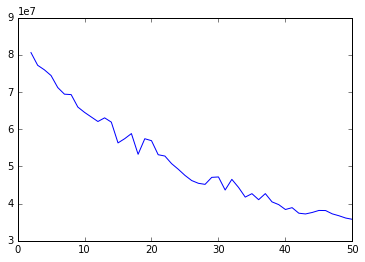

In [69]:
plt.clf()
plt.plot(pdErrors.clusters,pdErrors.wssse)
plt.show()

In [70]:
dfErrors=spark.createDataFrame(pdErrors)

In [71]:
dfErrors.printSchema()

root
 |-- clusters: long (nullable = true)
 |-- wssse: double (nullable = true)



In [30]:
dfClusterTransformed.count()

2570693

In [75]:
kmeans = BisectingKMeans(featuresCol="scaled_features").setK(30).setMinDivisibleClusterSize(30000).setSeed(666)

In [76]:
model = kmeans.fit(dfClusterTransformed)

In [77]:
model.save("/analytics/bc2_recommender/models/model02Mar")

In [15]:
model=BisectingKMeansModel.load("/analytics/bc2_recommender/models/model02Mar")

In [24]:
dfClusterFinal=model.transform(dfClusterTransformed).select('ACCOUNTPK','prediction')

In [27]:
dfClusterFinal.groupBy('prediction').count().orderBy('prediction').show(50)

+----------+-------+
|prediction|  count|
+----------+-------+
|         0|1038182|
|         1| 149984|
|         2|  81672|
|         3| 260194|
|         4|  66419|
|         5|  35717|
|         6|  95942|
|         7|  15959|
|         8|  65412|
|         9|   6884|
|        10|  48156|
|        11|   5941|
|        12|  25824|
|        13|  26403|
|        14| 210161|
|        15|  44016|
|        16|  45946|
|        17|   1997|
|        18|  45477|
|        19|  20960|
|        20|   9452|
|        21|  52996|
|        22|  20917|
|        23|  55269|
|        24|   6954|
|        25|  15887|
|        26|  41026|
|        27|  22931|
|        28|  24075|
|        29|  29940|
+----------+-------+



### Most popular product per cluster-family

In [74]:
dfFamProd=dfTemp2.groupBy('ACCOUNTPK','PRF_CD_FAMILIA','PRF_DS_FAMILIA',dfEM.IVA_CD_ITEM,'IVA_DS_ITEM') \
    .agg(sum('PURCHASES').alias('RATING'))

In [78]:
dfPopularProd=dfFamProd.join(dfClusterFinal,dfClusterFinal.ACCOUNTPK==dfFamProd.ACCOUNTPK).drop(dfClusterFinal.ACCOUNTPK)

In [79]:
dfPopularProd.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- PRF_CD_FAMILIA: long (nullable = true)
 |-- PRF_DS_FAMILIA: string (nullable = true)
 |-- IVA_CD_ITEM: long (nullable = true)
 |-- IVA_DS_ITEM: string (nullable = true)
 |-- RATING: long (nullable = true)
 |-- prediction: integer (nullable = true)



In [85]:
dfPopularProd.persist().count()

113672492

In [86]:
dfPopularProd.createOrReplaceTempView("dfPopularProd")

In [90]:
dfTop5Prod=spark.sql(''' 
    SELECT * FROM (
    SELECT prediction, PRF_CD_FAMILIA, PRF_DS_FAMILIA, IVA_CD_ITEM,IVA_DS_ITEM, RATING, 
    row_number() over (partition by prediction, PRF_CD_FAMILIA order by RATING desc) as orden
    FROM
    (SELECT prediction, PRF_CD_FAMILIA,PRF_DS_FAMILIA,IVA_CD_ITEM,IVA_DS_ITEM, sum(RATING) as RATING FROM dfPopularProd
    GROUP BY prediction, PRF_CD_FAMILIA,PRF_DS_FAMILIA,IVA_CD_ITEM,IVA_DS_ITEM) TOTAL
    ) FINAL
    WHERE orden<=5
    ''')

In [91]:
dfTop5Prod.write.parquet("/analytics/bc2_recommender/tables/dfTop5Prod13Mar", mode='overwrite')

In [28]:
dfTop5Prod=spark.read.parquet("/analytics/bc2_recommender/tables/dfTop5Prod13Mar")

In [33]:
dfTop5Prod.show(20)

+----------+--------------+--------------------+-----------+--------------------+------+-----+
|prediction|PRF_CD_FAMILIA|      PRF_DS_FAMILIA|IVA_CD_ITEM|         IVA_DS_ITEM|RATING|orden|
+----------+--------------+--------------------+-----------+--------------------+------+-----+
|         0|      20253453|    COMBOS CAFETERIA|    8679681|COMBO PAO MANTEIG...|    19|    1|
|         0|      20253453|    COMBOS CAFETERIA|    9392190|             COMBO 4|    17|    2|
|         0|      20253453|    COMBOS CAFETERIA|    9392564|             COMBO 9|    17|    3|
|         0|      20253453|    COMBOS CAFETERIA|    9392602|            COMBO 13|    11|    4|
|         0|      20253453|    COMBOS CAFETERIA|    8683360|COMBO PAO QUEIJO ...|     4|    5|
|         0|      30381356|DORMITORIO SACOS ...|    9600809|SACO DE DORMIR C ...|    75|    1|
|         0|      30381356|DORMITORIO SACOS ...|    9574212|SACO DE DORMIR CR...|    53|    2|
|         0|      30381356|DORMITORIO SACOS ...|  

In [37]:
dfTop5Prod.where(dfTop5Prod.PRF_CD_FAMILIA=='30381356').show(20, False)

+----------+--------------+--------------------------+-----------+------------------------------------+------+-----+
|prediction|PRF_CD_FAMILIA|PRF_DS_FAMILIA            |IVA_CD_ITEM|IVA_DS_ITEM                         |RATING|orden|
+----------+--------------+--------------------------+-----------+------------------------------------+------+-----+
|0         |30381356      |DORMITORIO SACOS DE DORMIR|9600809    |SACO DE DORMIR C COLCHONETE DUOCAMP |75    |1    |
|0         |30381356      |DORMITORIO SACOS DE DORMIR|9574212    |SACO DE DORMIR CRF 217X75CM OD043957|53    |2    |
|0         |30381356      |DORMITORIO SACOS DE DORMIR|9148540    |SACO DE DORMIR CRF 175X170XM        |18    |3    |
|0         |30381356      |DORMITORIO SACOS DE DORMIR|9100253    |SACO DE DORMIR 190X75CM             |17    |4    |
|2         |30381356      |DORMITORIO SACOS DE DORMIR|9600809    |SACO DE DORMIR C COLCHONETE DUOCAMP |11    |1    |
|2         |30381356      |DORMITORIO SACOS DE DORMIR|9574212   

In [97]:
dfTop5Prod.select('prediction','PRF_CD_FAMILIA').count()

305007

### ALS

In [99]:
als = ALS(rank=10, maxIter=5, userCol="userid", itemCol="itemid", seed=0, ratingCol="RATING", implicitPrefs=True,nonnegative=True)

In [100]:
model = als.fit(dfRecommender2)

In [101]:
model.rank

10

In [102]:
model.userFactors.show(truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------+
|id   |features                                                                                                                                |
+-----+----------------------------------------------------------------------------------------------------------------------------------------+
|10   |[0.04950075, 0.035951197, 0.0046184477, -0.2548798, -0.40663978, -0.42311248, 0.15018618, -0.05456966, -0.13830426, -0.3845248]         |
|40   |[-7.01544E-4, -0.42246595, -0.20613185, -0.5613107, -0.1749761, -0.32426882, 0.27154428, 0.080042824, 0.06424383, 0.18926226]           |
|64380|[0.0035406428, 0.0063627376, -0.0064999606, 4.639617E-4, -0.0014300647, 0.006610941, 0.005155592, 9.41042E-4, 9.152727E-4, 0.0020115033]|
|64430|[0.03535261, 0.07707989, 0.004762779, 0.07295724, -0.037575953, 0.013370853, -0.03388767, 0.005844283, 0.012891655, 7.33068

In [56]:
test = spark.createDataFrame([ (12538315, 10126423),(13627517, 90930103),(4, 10105417) ], ["userid", "itemid"])

In [57]:
testTrans=model.transform(test)

In [58]:
testTrans.show()

+--------+--------+-------------+
|  userid|  itemid|   prediction|
+--------+--------+-------------+
|12538315|10126423|      0.60689|
|13627517|90930103|1.30799635E-5|
|       4|10105417|   0.09522386|
+--------+--------+-------------+



In [104]:
dfTransformedTest=model.transform(dfRecommenderTest2)

In [115]:
dfTransformedTest.persist().count()

22636864

In [105]:
dfTransformedTest.printSchema()

root
 |-- userid: long (nullable = true)
 |-- itemid: long (nullable = true)
 |-- PRF_DS_FAMILIA: string (nullable = true)
 |-- RATING: long (nullable = true)
 |-- prediction: float (nullable = true)



In [157]:
dfTransformedTrain=model.transform(dfRecommender2)

In [158]:
dfTransformedTrain.persist().count()

83096133

In [127]:
dfTransformedTrain.printSchema()

root
 |-- userid: long (nullable = true)
 |-- itemid: long (nullable = true)
 |-- PRF_DS_FAMILIA: string (nullable = true)
 |-- RATING: long (nullable = true)
 |-- prediction: float (nullable = true)



### Evaluations methods

#### Method 1: Global formula

In [106]:
class RankBasedEvaluator():
    def __init__(self, user_col, rating_col, prediction_col):
        self._user_col = user_col
        self._rating_col = rating_col
        self._prediction_col = prediction_col

    def evaluate(self, spark, predictions):
        # I filter out NaN predictions
        predictions = predictions.filter("NOT ISNAN({0})".format(self._prediction_col))
        predictions.createOrReplaceTempView("predictions")

        denominator = predictions.groupBy().sum(self._rating_col).collect()[0][0]

        spark.sql("""SELECT {0}
                          , {1}
                          , PERCENT_RANK() OVER (PARTITION BY {0} ORDER BY {2} DESC) AS rank
                     FROM predictions""".format(self._user_col, self._rating_col,
                                                self._prediction_col)) \
             .createOrReplaceTempView("ratings_with_ranks")
        numerator = spark.sql("""SELECT SUM({0} * rank)
                                 FROM ratings_with_ranks""".format(self._rating_col)) \
                           .collect()[0][0]

        return numerator / denominator

    def transform_evaluate(self, spark, model, df):
        predictions = model.transform(df)
        return self.evaluate(spark, predictions)

#### Method 2: Averaging by customer

In [110]:
class RankBasedEvaluator2():
    def __init__(self, user_col, rating_col, prediction_col):
        self._user_col = user_col
        self._rating_col = rating_col
        self._prediction_col = prediction_col

    def evaluate(self, spark, predictions):
        predictions.createOrReplaceTempView("original_predictions")
        # I filter out NaN predictions
        spark.sql("""SELECT *
                     FROM original_predictions
                     WHERE NOT ISNAN({0})""".format(self._prediction_col)) \
             .createOrReplaceTempView("predictions")
        spark.sql("""SELECT {0}
                          , SUM({1}) as rating_sum
                     FROM predictions
                     GROUP BY {0}""".format(self._user_col, self._rating_col)) \
             .createOrReplaceTempView("rating_sums")
        spark.sql("""SELECT {0}
                          , {1}
                          , PERCENT_RANK() OVER (PARTITION BY {0} ORDER BY {2} DESC) AS rank
                     FROM predictions""".format(self._user_col, self._rating_col,
                                                self._prediction_col)) \
             .createOrReplaceTempView("ratings_with_ranks")
        spark.sql("""SELECT {0},
                     SUM({1} * rank) AS weighted_sum
                     FROM ratings_with_ranks
                     GROUP BY {0}""".format(self._user_col, self._rating_col)) \
             .createOrReplaceTempView("weighted_rating_sums")
        spark.sql("""SELECT weighted_rating_sums.*, rating_sums.rating_sum
                     FROM weighted_rating_sums
                     JOIN rating_sums
                       ON weighted_rating_sums.{0} = rating_sums.{0}""".format(self._user_col)) \
             .createOrReplaceTempView("joined_sums")

        result = spark.sql("""SELECT AVG(weighted_sum / rating_sum)
                              FROM joined_sums""")

        return result.collect()[0][0]

    def transform_evaluate(self, spark, model, df):
        predictions = model.transform(df)
        return self.evaluate(spark, predictions)

#### Evaluations

In [107]:
evaluator=RankBasedEvaluator('userid','RATING','prediction')

In [108]:
evaluator.evaluate(spark,dfTransformedTest)

0.4690345534762214

In [111]:
evaluator2=RankBasedEvaluator2('userid','RATING','prediction')

In [113]:
evaluator2.evaluate(spark,dfTransformedTest)

0.4111913770984898

In [120]:
dfTransformedTest.filter("NOT ISNAN(prediction)").where(col('prediction')<0.5).count()

13040148

In [128]:
dfTransformedTrain.describe().show()

+-------+-----------------+--------------------+--------------------+-----------------+-------------------+
|summary|           userid|              itemid|      PRF_DS_FAMILIA|           RATING|         prediction|
+-------+-----------------+--------------------+--------------------+-----------------+-------------------+
|  count|         83096133|            83096133|            83096133|         83096133|           83096133|
|   mean|7077693.071688787| 1.625423277291154E7|                null|1.913286951632274|0.37900755572742645|
| stddev|4537729.256233302|1.1175433091491835E7|                null| 2.24607336990005| 0.2806633680101887|
|    min|                4|            10105408|0 A 12 MESES BERMUDA|                1|        -0.46625134|
|    max|         13627517|            90930103|  XAROPE OUTRO SABOR|              973|          1.6338861|
+-------+-----------------+--------------------+--------------------+-----------------+-------------------+



In [129]:
evaluator.evaluate(spark,dfTransformedTrain)

0.4143286927517335

In [130]:
evaluator2.evaluate(spark,dfTransformedTrain)

0.40166638710275415

#### Best parameters

In [148]:
ranks=[10,20]

In [149]:
lambdas=[0.01,0.1]

In [150]:
alphas=[1.0,5.0]

In [151]:
for rank in ranks:
    for lambd in lambdas:
        for alpha in alphas:
            als = ALS(rank=rank, maxIter=10, userCol="userid", itemCol="itemid", seed=0, ratingCol="RATING", \
                      implicitPrefs=True, regParam=lambd,alpha=alpha,nonnegative=True )
            model = als.fit(dfRecommender2)
            dfTransformedTest=model.transform(dfRecommenderTest2)
            dfTransformedTest.persist().count()
            evaluacion=evaluator.evaluate(spark,dfTransformedTest)
            dfTransformedTest.unpersist()
            print("Rango {0}, lambda {1}, alpha {2} -> {3}".format(rank,lambd,alpha,evaluacion))
            
            

Rango 10, lambda 0.01, alpha 1.0 -> 0.46821695914331757
Rango 10, lambda 0.01, alpha 5.0 -> 0.4719210233214084
Rango 10, lambda 0.1, alpha 1.0 -> 0.46755560938381885
Rango 10, lambda 0.1, alpha 5.0 -> 0.46786484076303353
Rango 20, lambda 0.01, alpha 1.0 -> 0.4654762274748008
Rango 20, lambda 0.01, alpha 5.0 -> 0.0
Rango 20, lambda 0.1, alpha 1.0 -> 0.4657528228841245
Rango 20, lambda 0.1, alpha 5.0 -> 0.4726229164961475


In [156]:
model.itemFactors.show(5)

+--------+--------------------+
|      id|            features|
+--------+--------------------+
|10105410|[0.0, 0.22157684,...|
|10105420|[0.058929723, 0.2...|
|10107820|[0.0, 0.1795444, ...|
|10107930|[0.039082967, 0.0...|
|10108310|[0.026259428, 0.1...|
+--------+--------------------+
only showing top 5 rows



In [38]:
als = ALS(rank=10, maxIter=10, userCol="userid", itemCol="itemid", seed=0, ratingCol="RATING", \
                      implicitPrefs=True, regParam=0.1,alpha=1,nonnegative=True)

In [39]:
model = als.fit(dfRecommender2)

In [49]:
dfTransformedTest=model.transform(dfRecommenderTest2)
dfTransformedTest.persist().count()


22636864

In [64]:
dfTransformedTest.where(dfTransformedTest.RATING>30).where(dfTransformedTest.userid!=8).orderBy('userid','itemid').show(100)

+-------+--------+--------------------+------+------------+
| userid|  itemid|      PRF_DS_FAMILIA|RATING|  prediction|
+-------+--------+--------------------+------+------------+
| 273827|20232911|       MASSA FRANCES|    32|  0.95777994|
| 295075|10148434|            NATALINA|    34|         NaN|
| 325924|30391504|   RACAO UMIDA SACHE|   106|   0.9946916|
| 326802|30391504|   RACAO UMIDA SACHE|    39|    0.959075|
| 333285|10126918|     ESMALTE REGULAR|    38|0.0013956989|
| 358812|20225301|        CONVENCIONAL|    34|   1.0422972|
| 369261|20225301|        CONVENCIONAL|    33|    1.051559|
| 378325|30391504|   RACAO UMIDA SACHE|    56|    1.097845|
| 402253|10148434|            NATALINA|    37|         NaN|
| 442117|10142123|TORRADO MOIDO ALM...|    44|  0.82005084|
| 456314|10148433|              BASICA|    32|   0.5725901|
| 459646|20253506|   ROTISSERIA GRANEL|    43|  0.44298536|
| 505707|20253506|   ROTISSERIA GRANEL|    32|  0.38199434|
| 508314|30391403|   RACAO UMIDA SACHE| 

In [ ]:
evaluator.evaluate(spark,dfTransformedTest)

In [147]:
dfTransformedTest.select('prediction').filter("NOT ISNAN(prediction)").describe().show()

+-------+-------------------+
|summary|         prediction|
+-------+-------------------+
|  count|           20841127|
|   mean| 0.3940158237906615|
| stddev|0.31093469043488986|
|    min|                0.0|
|    max|           1.642262|
+-------+-------------------+



In [170]:
model.userFactors.select('features')[0][0]

Column<b'features[0]'>

In [160]:
dfTransformedTrain.head()

Row(userid=4856313, itemid=30373204, PRF_DS_FAMILIA='COLCHOES CASAL ESPUMA', RATING=1, prediction=0.0008301583002321422)

In [126]:
dir()

['ALS',
 'ALSModel',
 'ArrayType',
 'BinaryType',
 'BisectingKMeans',
 'BisectingKMeansModel',
 'BooleanType',
 'ByteType',
 'Comm',
 'DataType',
 'DateType',
 'DecimalType',
 'DoubleType',
 'ElementwiseProduct',
 'FloatType',
 'In',
 'IntegerType',
 'KMeans',
 'KMeansModel',
 'LongType',
 'Magics',
 'MapType',
 'ModelRepositoryMagics',
 'MyClass',
 'NullType',
 'Out',
 'PCA',
 'PCAModel',
 'Path',
 'Pipeline',
 'PipelineModel',
 'RankBasedEvaluator',
 'RankBasedEvaluator2',
 'SQLContext',
 'ShortType',
 'SimpleSparkSerializer',
 'SparkContext',
 'SparkSession',
 'StandardScaler',
 'StorageLevel',
 'StringType',
 'StructField',
 'StructType',
 'TimestampType',
 'VectorAssembler',
 '_',
 '_101',
 '_108',
 '_113',
 '_115',
 '_119',
 '_120',
 '_121',
 '_124',
 '_30',
 '_36',
 '_38',
 '_39',
 '_40',
 '_42',
 '_44',
 '_45',
 '_47',
 '_49',
 '_5',
 '_50',
 '_51',
 '_53',
 '_65',
 '_81',
 '_85',
 '_94',
 '_95',
 '_96',
 '_97',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__lo